## Setup

Before execution of the notebook, make sure that all packages implemented are reloaded and imported.

In [2]:
import importlib
import Models.RelationshipCalculator
import Python_API_Handlers.MarvelApiHandler
import Helpers.Helper
importlib.reload(Models.RelationshipCalculator)
importlib.reload(Python_API_Handlers.MarvelApiHandler)
importlib.reload(Helpers.Helper)
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from Python_API_Handlers.MarvelApiHandler import MarvelApiHandler
from Helpers.Helper import HelperClass
from Models.RelationshipCalculator import RelationShipCalculator

In [3]:
def get_entities_count_configuration(entities_count_config_path):
    """Returns a dictionary representing information about the count of the Marvel API entities (comics, series, events, heroes, stories).
    This dictionary is calculated from the JSON configuration under the given path.

    Args:
        entities_count_config_path (str): The path to the file containing the JSON configuration with information
        about the total count of the entities (totalHeroCount, totalComicsCount, totalSeriesCount, totalEventsCount, totalStoriesCount).

    Raises:
        FileNotFoundError: Is thrown if the configuration file does not exist.
        ValueError: Is thrown if the configuration file is empty.

    Returns:
        dict: The dictionary containing the count attributes.
    """
    if not(os.path.isfile(entities_count_config_path)):
        raise FileNotFoundError('Could not find the config file!')
    if os.stat(entities_count_config_path).st_size == 0:
        raise ValueError("Invalid config file detected!")

    helper = HelperClass()
    config_data = helper.load_json_data(entities_count_config_path)
    total_hero_count = config_data['totalHeroCount']
    total_comics_count = config_data['totalComicsCount']
    total_series_count = config_data['totalSeriesCount']
    total_stories_count = config_data['totalStoriesCount']
    total_events_count = config_data['totalEventsCount']
    result_dict = dict()
    result_dict['totalHeroCount'] = total_hero_count
    result_dict['totalComicsCount'] = total_comics_count
    result_dict['totalSeriesCount'] = total_series_count
    result_dict['totalStoriesCount'] = total_stories_count
    result_dict['totalEventsCount'] = total_events_count
    return result_dict

In [4]:
def store_total_entities_amount(marvel_api_config_json_path, entities_amount_config_json_path):
    """Stores the total amount of entities (heroes, comics, series, events, stories) to a JSON configuration file.
    These information is calculated using the API requests to the Marvel API.
    The file is created if it does not exist.
    The data is fetched if the file is empty.
    If some data is already present, no data is fetched.

    Args:
        marvel_api_config_json_path (str): Represents the path to the JSON configuration containing information about the Marvel API.
        entities_amount_config_json_path (str): The path to the file containing the JSON configuration with information
        about the total count of the entities (totalHeroCount, totalComicsCount, totalSeriesCount, totalEventsCount, totalStoriesCount).

    Raises:
        FileNotFoundError: Is thrown if the JSON configuration file containing information about the Marvel API does not exist.
    """
    if not(os.path.exists(marvel_api_config_json_path)):
        raise FileNotFoundError("The file under the path marvel_api_config_json_path does not exist!")
    if not(os.path.isfile(entities_amount_config_json_path)):
        open(entities_amount_config_json_path, "x")
    if os.stat(entities_amount_config_json_path).st_size != 0:
        return
     
    apiHandler = MarvelApiHandler(marvel_api_config_json_path)
    comicsCount = apiHandler.get_total_entity_count('comics')
    seriesCount = apiHandler.get_total_entity_count('series')
    storiesCount = apiHandler.get_total_entity_count('stories')
    eventsCount = apiHandler.get_total_entity_count('events')
    characters = apiHandler.get_total_entity_count('characters')
    toWrite = {        
     "totalHeroCount": characters,
    "totalComicsCount": comicsCount,
    "totalSeriesCount": seriesCount,
    "totalStoriesCount": storiesCount,
    "totalEventsCount": eventsCount
    }

    with open(entities_amount_config_json_path, "w") as outfile:
        json.dump(toWrite, outfile)

In [5]:
store_total_entities_amount('./API_Configs/marvel-api-config.json', './API_Configs/entities-count-config.json')

## Characters from the Marvel API
In the first step, the heroes from the Marvel API have to be fetched.
For this purpose, the method **get_all_characters()** from the class **MarvelApiHandler.py** has to be called.
The data is stored as JSON.

### Storing characters data in a JSON file

In [6]:
def store_heroes_in_json_file(marvel_api_config_json_path, heroes_json_path, entities_count_config_path):
    """Fetches all characters from the Marvel API and stores them in a JSON file under the given path.
    The file is created if it does not exist.
    The data is fetched if the file is empty.
    If some data is already present, no characters are fetched.

    Args:
        marvel_api_config_json_path (str): Represents the path to the JSON configuration containing information about the Marvel API.
        heroes_json_path (str): Represents the path to the JSON configuration containing a JSON array representing the characters of the Marvel universe.
        The characters are represented as JSON objects containing more information about them.
        entities_count_config_path (str): The path to the file containing the JSON configuration with information
        about the total count of the entities (totalHeroCount, totalComicsCount, totalSeriesCount, totalEventsCount, totalStoriesCount).

    Raises:
        FileNotFoundError: Is thrown if the JSON configuration file containing information about the Marvel API does not exist.
        FileNotFoundError: Is thrown if the configuration file containing the entities count does not exist.
    """
    if not(os.path.exists(marvel_api_config_json_path)):
        raise FileNotFoundError("The file under the path marvel_api_config_json_path does not exist!")
    if not(os.path.isfile(heroes_json_path)):
        open(heroes_json_path, "x")
    if os.path.isfile(heroes_json_path):
        if os.stat(heroes_json_path).st_size != 0:
            return
    if not(os.path.isfile(entities_count_config_path)):
        raise FileNotFoundError("The file path entities_count_config_path does not exist!")
    
    apiHandler = MarvelApiHandler(marvel_api_config_json_path)
    entities_count_config = get_entities_count_configuration(entities_count_config_path)
    heroes_json = apiHandler.get_all_characters(entities_count_config['totalHeroCount'])
    heroes_json_string = json.dumps(heroes_json)
    with open(heroes_json_path, 'w') as outfile:
        outfile.write(heroes_json_string)

In order to avoud repeated API calls, the JSON object will be saved into a file, if it already is not empty.

In [7]:
store_heroes_in_json_file('./API_Configs/marvel-api-config.json', './DataSourcesJSON/characters.json', './API_Configs/entities-count-config.json')

### Cleaning the data and storing in a Pandas data frame

In the first step the needed attributes are stored in variables.
In the next step, a Pandas data frame is created.

In [8]:
def create_characters_data_frame(heroes_json_path):
  """Creates a data frame containing information about characters that can be found in a JSON array in the file under the given path.
    Format: ID | Name | Description | Amount of comics | Amount of series | Amount of stories | Amount of events 

  Args:
      heroes_json_path (str): Represents the path to the JSON configuration containing a JSON array representing the characters of the Marvel universe.
      The characters are represented as JSON objects containing more information about them.

  Raises:
      FileNotFoundError: Is thrown if the configuration containing the characters does not exist.

  Returns:
      DataFrame: The data frame containing the information about the characters.
  """
  if not(os.path.isfile(heroes_json_path)):
      raise FileNotFoundError('Could not find the JSOn file!')

  helper = HelperClass()
  data = helper.load_json_data(heroes_json_path)
  ids = [el['id'] for el in data]
  names = [el['name'] for el in data]
  descriptions = [el['description'] for el in data]
  comics_count = [el['comics']['available'] for el in data]
  series_count = [el['series']['available'] for el in data]
  stories_count = [el['stories']['available'] for el in data]
  events_count = [el['events']['available'] for el in data]
  frame_data = {'ID': ids,
              'Name': names,
              'Description': descriptions,
              'Amount of comics': comics_count,
              'Amount of series': series_count,
              'Amount of stories': stories_count,
              'Amount of events': events_count}

  df = pd.DataFrame(frame_data)
  df.set_index('ID', inplace=True)
  return df

In [9]:

df = create_characters_data_frame('./DataSourcesJSON/characters.json')
df

,Name,Description,Amount of comics,Amount of series,Amount of stories,Amount of events
ID,,,,,,
1011334,3-D Man,,12,3,21,1
1017100,A-Bomb (HAS),Rick Jones has been Hulk's best bud since day ...,4,2,7,0
1009144,A.I.M.,AIM is a terrorist organization bent on destro...,53,36,57,0
1010699,Aaron Stack,,14,3,27,0
1009146,Abomination (Emil Blonsky),"Formerly known as Emil Blonsky, a spy of Sovie...",58,28,68,1
...,...,...,...,...,...,...
1011515,Zeus,Zeus ruled a peaceful Olympus for centuries wh...,36,13,43,0
1011127,Zodiak,"Twelve demons merged with Norman Harrison, who...",1,1,1,0
1009741,Zombie (Simon Garth),War hero Simon Garth was turned into a zombie ...,1,1,1,0


## Determination of popularity based on the number of appearances of the individual characters

The popularity was determined by the calculation of the amount of appearances in the following entities: comics, series, stories and events.
The TOP 10 characters are taken into account.

In [10]:
def get_frame_key_based_on_entity_type(entity_type):
    """Returns a data frame key.
    This key is used to retrieve specific columns from the data frame representing the amount of entities of certain entity type
    for a character.

    Args:
        entity_type (str): The requested entity type (comics, series, stories or events).

    Raises:
        TypeError: Is thrown if the entity type is no string.
        ValueError: Is thrown if the entity type is not in the allowed entities.

    Returns:
        str: The data frame key corresponding to the relevant column. 
    """
    if type(entity_type) != str:
        raise TypeError("entity_type has to be a string!")
    if entity_type not in ['comics', 'series', 'stories', 'events']:
        raise ValueError("entity_type must be one of 'comics', 'series', 'stories', 'events")
    
    result = ''

    if entity_type == 'comics':
        result = 'Amount of comics'
    if entity_type == 'series':
        result = 'Amount of series'
    if entity_type == 'stories':
        result = 'Amount of stories'
    if entity_type == 'events':
        result = 'Amount of events'
    
    return result

In [11]:
def get_config_key_based_on_entity_type(entity_type):
    """Converts the entity type (comics, series, stories or events) to the corresponding
    JSON object key used to retrieve the total count of the mentioned entities from the JSON object.

    Args:
        entity_type (str): The requested entity type (comics, series, stories or events).

    Raises:
        TypeError: Is thrown if the entity type is no string.
        ValueError: Is thrown if the entity type is not in the allowed entities.

    Returns:
        str: The JSON object key corresponding to the relevant entity type. 
    """
    if type(entity_type) != str:
        raise TypeError("entity_type has to be a string!")
    if entity_type not in ['comics', 'series', 'stories', 'events']:
        raise ValueError("entity_type must be one of 'comics', 'series', 'stories', 'events")
    
    result = ''

    if entity_type == 'comics':
        result = 'totalComicsCount'
    if entity_type == 'series':
        result = 'totalSeriesCount'
    if entity_type == 'stories':
        result = 'totalStoriesCount'
    if entity_type == 'events':
        result = 'totalEventsCount'
    
    return result

In [12]:
def get_most_popular_in_entity_type(heroes_json_path, entity_type, count):
    """Returns a data frame representing TOP X most popular characters in the given entity type (comics, series, stories, events).
    The characters are read from the JSON configuration where they are stored as an arry of JSON objects.
    The popularity is expressed by the frequency of occurrence in the given entity type (the most frequent appearance = the most popular).
    The TOP X are calculated in descending order by the amount of appearances in the given entity type.
    Format: ID | Name | Description | Amount of comics | Amount of series | Amount of stories | Amount of events 

    Args:
        heroes_json_path (str): Represents the path to the JSON configuration containing a JSON array representing the characters of the Marvel universe.
        The characters are represented as JSON objects containing more information about them.
        entity_type (str): The requested entity type (comics, series, stories or events).
        count (int): Amount of TOP X to retrieve.

    Raises:
        TypeError: Is thrown if the entity type is no string.
        TypeError: Is thrown if count is no integer.
        ValueError: Is thrown if the entity type is not in the allowed entities.
        FileNotFoundError: Is thrown if the configuration is not found.
        TypeError: Is thrown if the count is in invalid range.

    Returns:
        DataFrame: The data frame containing the most popular characters.
    """
    if type(entity_type) != str:
        raise TypeError("entity_type has to be a string!")
    if type(count) != int:
        raise TypeError("count must be an integer!")
    if entity_type not in ['comics', 'series', 'stories', 'events']:
        raise ValueError("entity_type must be one of 'comics', 'series', 'stories', 'events")
    if not(os.path.isfile(heroes_json_path)):
      raise FileNotFoundError('Could not find the JSOn file!')
    
    helper = HelperClass()
    
    heroes_frame = create_characters_data_frame(heroes_json_path)

    if not(helper.is_within_range(count, 0, len(heroes_frame.index))):
        raise TypeError("count must be within range!")
    
    key = get_frame_key_based_on_entity_type(entity_type)
    df_sorted_by_amount_of_entities = heroes_frame.sort_values([key], ascending=False)
    df_sorted_by_amount_of_entities = df_sorted_by_amount_of_entities[:count]
    return df_sorted_by_amount_of_entities

In [13]:
def plot_data(bar_title, rotation, x, y, xlabel, ylabel): 
    """Plots the data provided by the parameters (x and y).

    Args:
        bar_title (str): The title of the plot.
        rotation (int): The rotation degree.
        x (list): The x data.
        y (list): The y data.
        xlabel (str): Label of the x axis.
        ylabel (str): Label of the y axis.

    Raises:
        TypeError: Is thrown if bar_title is not a string.
        TypeError: Is thrown if rotation is not an integer.
        TypeError: Is thrown if x is not a list.
        TypeError: Is thrown if y is not a list.
        TypeError: Is thrown if xlabel is not a string.
        TypeError: Is thrown if ylabel is not a string.
    """
    if type(bar_title) != str:
        raise TypeError("bar_title has to be a string!")
    if type(rotation) != int:
        raise TypeError("rotation must be an integer!")
    if type(x) != list:
        raise TypeError("x must be a list!")
    if type(y) != list:
        raise TypeError("y must be a list!")
    if type(xlabel) != str:
        raise TypeError("xlabel has to be a string!")
    if type(ylabel) != str:
        raise TypeError("ylabel has to be a string!")
    plt.bar(x, y)
    plt.xticks(rotation=rotation)
    plt.title(bar_title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()

In [14]:
def plot_character_popularity(entities_count_configuration, heroes_configuration, top_count, entity_type):
  """Plots the character populary based on the parameters.

  Args:
      entities_count_configuration (str): The path to the file containing the JSON configuration with information
      about the total count of the entities (totalHeroCount, totalComicsCount, totalSeriesCount, totalEventsCount, totalStoriesCount).
      heroes_configuration (str):  Represents the path to the JSON configuration containing a JSON array representing the characters of the Marvel universe.
      The characters are represented as JSON objects containing more information about them.
      top_count (int): Amount of TOP X to retrieve.
      entity_type (str): The requested entity type (comics, series, stories or events).

  Raises:
      FileNotFoundError: Is thrown if the entities count configuration file does not exist.
      FileNotFoundError: Is thrown if the configuration containing the characters is not found.
      TypeError: Is thrown if top_count is not an integer.
      TypeError: Is thrown if entity_type is not a string.
      ValueError: Is thrown if the entity type is not in the allowed entities.
  """
  if not(os.path.isfile(entities_count_configuration)):
    raise FileNotFoundError('Could not find the JSON file!')
  if not(os.path.isfile(heroes_configuration)):
    raise FileNotFoundError('Could not find the JSON file!')
  if type(top_count) != int:
      raise TypeError("top_count must be an integer!")
  if type(entity_type) != str:
      raise TypeError("entity_type has to be a string!")
  if entity_type not in ['comics', 'series', 'stories', 'events']:
      raise ValueError("entity_type must be one of 'comics', 'series', 'stories', 'events")
  
  config = get_entities_count_configuration(entities_count_configuration)
  top_popular = get_most_popular_in_entity_type(heroes_configuration, entity_type, top_count)
  frame_key = get_frame_key_based_on_entity_type(entity_type)
  config_key = get_config_key_based_on_entity_type(entity_type)
  entity_amount_relative_percentages = [el / config[config_key]  for el in top_popular[frame_key]]
  x = top_popular['Name']
  y = entity_amount_relative_percentages
  entities_bar_title = f'Popularity based on appearance in {entity_type}'
  rotation = 75
  xlabel = f'Top {top_count} Characters'
  ylabel = f'Appearance amount (relative), n = {config[config_key]}'
  plot_data(entities_bar_title, rotation, list(x), list(y), xlabel, ylabel)

### Determination of popularity based on the number of appearances in the comics

For this purpose, the data is sorted in descending order by the **Amount of comics**.

In [15]:
df = get_most_popular_in_entity_type('./DataSourcesJSON/characters.json', 'comics', 10)
df

,Name,Description,Amount of comics,Amount of series,Amount of stories,Amount of events
ID,,,,,,
1009610,Spider-Man (Peter Parker),"Bitten by a radioactive spider, high school st...",4434,1199,6417,37
1009726,X-Men,Feared and hated by humans because they're dif...,3972,1011,5648,42
1009368,Iron Man,"Wounded, captured and forced to build a weapon...",2727,680,4052,31
1009718,Wolverine,Born with super-human senses and the power to ...,2655,732,3669,42
1009220,Captain America,"Vowing to serve his country any way he could, ...",2511,722,3672,30
1009165,Avengers,Earth's Mightiest Heroes joined forces to take...,2237,690,3068,32
1009664,Thor,"As the Norse God of thunder and lightning, Tho...",1886,555,2792,27
1009351,Hulk,Caught in a gamma bomb explosion while trying ...,1785,545,2675,26
1009299,Fantastic Four,"After being exposed to cosmic rays, Reed Richa...",1529,438,2399,24


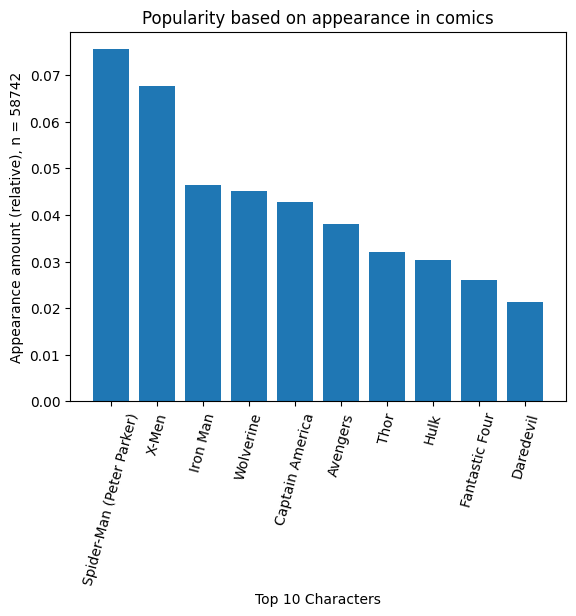

In [16]:
plot_character_popularity('./API_Configs/entities-count-config.json', './DataSourcesJSON/characters.json', 10, 'comics')

### Determination of popularity based on the number of appearances in the series

For this purpose, the data is sorted in descending order by the **Amount of series**.

In [17]:
df = get_most_popular_in_entity_type('./DataSourcesJSON/characters.json', 'series', 10)
df

,Name,Description,Amount of comics,Amount of series,Amount of stories,Amount of events
ID,,,,,,
1009610,Spider-Man (Peter Parker),"Bitten by a radioactive spider, high school st...",4434,1199,6417,37
1009726,X-Men,Feared and hated by humans because they're dif...,3972,1011,5648,42
1009718,Wolverine,Born with super-human senses and the power to ...,2655,732,3669,42
1009220,Captain America,"Vowing to serve his country any way he could, ...",2511,722,3672,30
1009165,Avengers,Earth's Mightiest Heroes joined forces to take...,2237,690,3068,32
1009368,Iron Man,"Wounded, captured and forced to build a weapon...",2727,680,4052,31
1009664,Thor,"As the Norse God of thunder and lightning, Tho...",1886,555,2792,27
1009351,Hulk,Caught in a gamma bomb explosion while trying ...,1785,545,2675,26
1009299,Fantastic Four,"After being exposed to cosmic rays, Reed Richa...",1529,438,2399,24


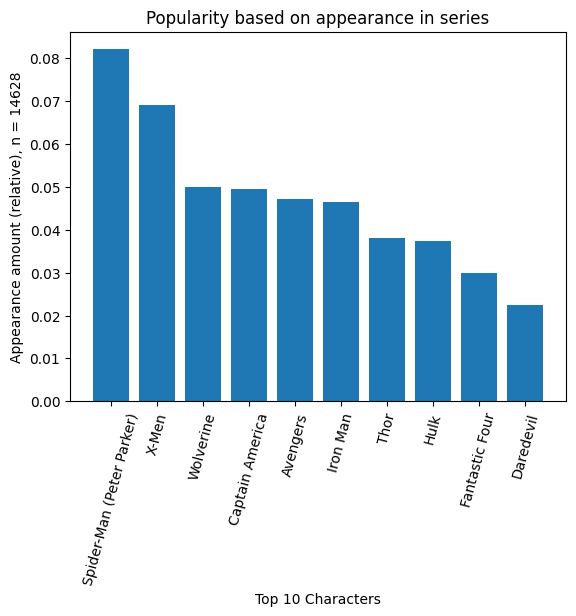

In [18]:
plot_character_popularity('./API_Configs/entities-count-config.json', './DataSourcesJSON/characters.json', 10, 'series')

### Determination of popularity based on the number of appearances in the stories

For this purpose, the data is sorted in descending order by the **Amount of stories**.

In [19]:
df = get_most_popular_in_entity_type('./DataSourcesJSON/characters.json', 'stories', 10)
df

,Name,Description,Amount of comics,Amount of series,Amount of stories,Amount of events
ID,,,,,,
1009610,Spider-Man (Peter Parker),"Bitten by a radioactive spider, high school st...",4434,1199,6417,37
1009726,X-Men,Feared and hated by humans because they're dif...,3972,1011,5648,42
1009368,Iron Man,"Wounded, captured and forced to build a weapon...",2727,680,4052,31
1009220,Captain America,"Vowing to serve his country any way he could, ...",2511,722,3672,30
1009718,Wolverine,Born with super-human senses and the power to ...,2655,732,3669,42
1009165,Avengers,Earth's Mightiest Heroes joined forces to take...,2237,690,3068,32
1009664,Thor,"As the Norse God of thunder and lightning, Tho...",1886,555,2792,27
1009351,Hulk,Caught in a gamma bomb explosion while trying ...,1785,545,2675,26
1009299,Fantastic Four,"After being exposed to cosmic rays, Reed Richa...",1529,438,2399,24


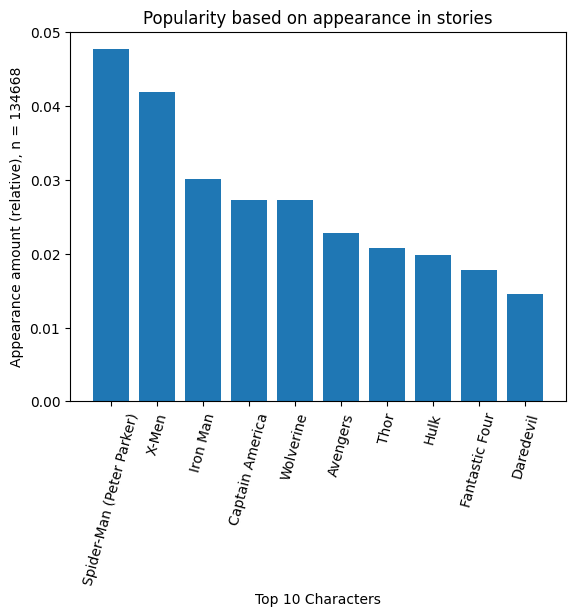

In [20]:
plot_character_popularity('./API_Configs/entities-count-config.json', './DataSourcesJSON/characters.json', 10, 'stories')

### Determination of popularity based on the number of appearances in the events

For this purpose, the data is sorted in descending order by the **Amount of events**.

In [21]:
df = get_most_popular_in_entity_type('./DataSourcesJSON/characters.json', 'events', 10)
df

,Name,Description,Amount of comics,Amount of series,Amount of stories,Amount of events
ID,,,,,,
1009726,X-Men,Feared and hated by humans because they're dif...,3972,1011,5648,42
1009718,Wolverine,Born with super-human senses and the power to ...,2655,732,3669,42
1009610,Spider-Man (Peter Parker),"Bitten by a radioactive spider, high school st...",4434,1199,6417,37
1009165,Avengers,Earth's Mightiest Heroes joined forces to take...,2237,690,3068,32
1009368,Iron Man,"Wounded, captured and forced to build a weapon...",2727,680,4052,31
1009220,Captain America,"Vowing to serve his country any way he could, ...",2511,722,3672,30
1009629,Storm,Ororo Monroe is the descendant of an ancient l...,888,229,1030,30
1009175,Beast,,832,222,926,30
1009257,Cyclops,,990,291,1106,29


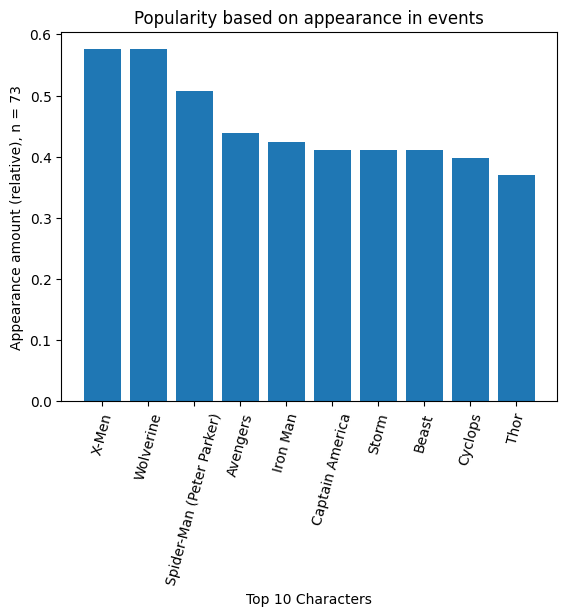

In [22]:
plot_character_popularity('./API_Configs/entities-count-config.json', './DataSourcesJSON/characters.json', 10, 'events')

### Conclusion


With Spider-Man and X-Men occupying the top two spots in Comics, Series and Events, it is clear that they enjoy the greatest popularity among published comic books.
Since Wolverine clearly leads in the events and almost equals the X-Men in terms of percentage, he can be seen as a stand-in for the X-Men.
Spider-Man clearly has a leading role.

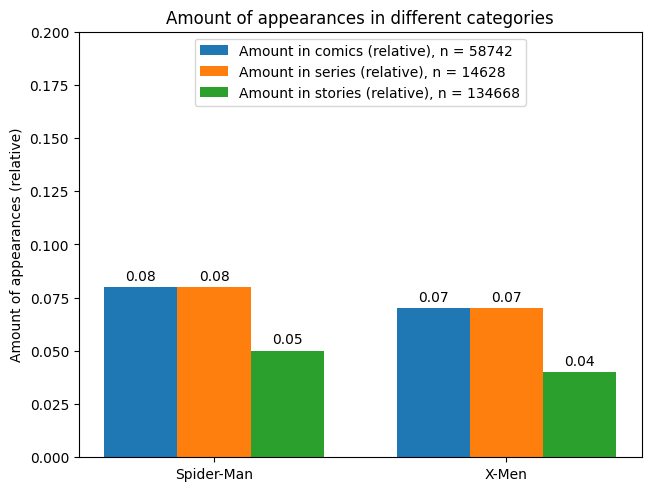

In [23]:
heroes_json_path = './DataSourcesJSON/characters.json'
entities_count_config_path = './API_Configs/entities-count-config.json'
most_common_characters = ('Spider-Man', 'X-Men')
entities_count_config = get_entities_count_configuration(entities_count_config_path)
two_most_common_comics = get_most_popular_in_entity_type(heroes_json_path, 'comics', 2)
two_most_common_comics_percentages = [round(el / entities_count_config['totalComicsCount'], 2)  for el in two_most_common_comics['Amount of comics']]
two_most_common_series = get_most_popular_in_entity_type(heroes_json_path, 'series', 2)
two_most_common_series_percentages = [round(el / entities_count_config['totalSeriesCount'], 2)  for el in two_most_common_series['Amount of series']]
two_most_common_stories = get_most_popular_in_entity_type(heroes_json_path, 'stories', 2)
two_most_common_stories_percentages = [round(el / entities_count_config['totalStoriesCount'], 2)  for el in two_most_common_stories['Amount of stories']]
percentages = {
    f'Amount in comics (relative), n = {entities_count_config["totalComicsCount"]}': two_most_common_comics_percentages,
    f'Amount in series (relative), n = {entities_count_config["totalSeriesCount"]}': two_most_common_series_percentages,
    f'Amount in stories (relative), n = {entities_count_config["totalStoriesCount"]}': two_most_common_stories_percentages
}

x = np.arange(len(most_common_characters)) 
width = 0.25 
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in percentages.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, rotation=0)
    multiplier += 1

ax.set_ylabel('Amount of appearances (relative)')
ax.set_title('Amount of appearances in different categories')
ax.set_xticks(x + width, most_common_characters)
ax.legend(loc='upper center', ncols=1)
ax.set_ylim(0, 0.2)
plt.show()

The following section examines why Spider-Man was able to achieve the greatest popularity.
This should examine if the popularity of Spider-Man is only coincidence.

## Possible reasons for popularity of Spider-Man

Since the determination of popularity based on the number of appearances may be random, this section attempts to substantiate the reason for this finding through the popularity in the films.
For this purpose, the data used to determine the popularity in the movies is loaded from a **.csv** file containing the data about superhero movies from the Marvel universe.
In the first step, some basic data cleaning is done.

In [24]:
def convert_dollar_value_to_float(input_value):
    """Converts a dollar value of the format $xxx.xxx to float.

    Args:
        input_value (str): The input value to convert.

    Raises:
        TypeError: Is thrown if the input value is no string.
        Exception: Is thrown if an invalid operation is detected.

    Returns:
        float: The converted value.
    """
    if type(input_value) == float:
        return input_value
    if type(input_value) != str:
        raise TypeError('input_value has to be string')
    if input_value == 'na':
        return float('nan')
    if input_value.startswith('$'):
        return float(input_value[1:])
    raise Exception('Invalid operation1')

In [25]:
def get_movies_frame(movie_csv_path):
    """Returns a data frame containing information about the movies read from the csv file at the given path.
    Format: Distributor | UsReleaseDate | BudgetInDolMill | NorthAmOpeningWeekendDolMill | NorthAmericaDolMill | OtherTerritoriesDolMill | WorldwideDolMill 

    Args:
        movie_csv_path (str): Path to the csv file containing information about the Marvel movies.

    Raises:
        FileNotFoundError: Is thrown if the file at the given path is not found.

    Returns:
        DataFrame: The data frame containing the information about the movies.
    """
    if not(os.path.isfile(movie_csv_path)):
      raise FileNotFoundError('Could not find the csv file!')
    
    movies_frame = pd.read_csv(movie_csv_path, delimiter=',', encoding = "ISO-8859-1")
    movies_frame.set_index('Title', inplace=True)
    movies_frame = movies_frame[(movies_frame.index.str.match('Total') == False) & (movies_frame.index.str.match('Average') == False)]

    for col in movies_frame.columns:
        if col.startswith('Distrib'):
            movies_frame.rename(columns={col: 'Distributor'}, inplace=True)
        if col.startswith('Release'):
            movies_frame.rename(columns={col: 'UsReleaseDate'}, inplace=True)
        if col.startswith('Bud'):
            movies_frame.rename(columns={col: 'BudgetInDolMill'}, inplace=True)
        if col.startswith('Opening'):
            movies_frame.rename(columns={col: 'NorthAmOpeningWeekendDolMill'}, inplace=True)
        if col.startswith('North'):
            movies_frame.rename(columns={col: 'NorthAmericaDolMill'}, inplace=True)    
        if col.startswith('Other'):
            movies_frame.rename(columns={col: 'OtherTerritoriesDolMill'}, inplace=True)      
        if col.startswith('World'):
            movies_frame.rename(columns={col: 'WorldwideDolMill'}, inplace=True)            
        
    movies_frame['BudgetInDolMill'] = [convert_dollar_value_to_float(el) for el in movies_frame['BudgetInDolMill']]
    movies_frame['NorthAmOpeningWeekendDolMill'] = [convert_dollar_value_to_float(el) / 1000000 for el in movies_frame['NorthAmOpeningWeekendDolMill']]
    movies_frame['NorthAmericaDolMill'] = [convert_dollar_value_to_float(el) / 1000000 for el in movies_frame['NorthAmericaDolMill']]
    movies_frame['OtherTerritoriesDolMill'] = [convert_dollar_value_to_float(el) / 1000000 for el in movies_frame['OtherTerritoriesDolMill']]
    movies_frame['WorldwideDolMill'] = [convert_dollar_value_to_float(el) / 1000000 for el in movies_frame['WorldwideDolMill']]
    return movies_frame

In [26]:
df = get_movies_frame('./DataSourcesCSV/marvel.csv')
df

,Distributor,UsReleaseDate,BudgetInDolMill,NorthAmOpeningWeekendDolMill,NorthAmericaDolMill,OtherTerritoriesDolMill,WorldwideDolMill
Title,,,,,,,
Howard the Duck,Universal Pictures,August 1 1986,37.0,5.070136,16.295774,21.667000,37.962774
Blade,New Line Cinema,August 21 1998,45.0,17.073856,70.087718,61.095812,131.183530
X-Men,20th Century Fox,July 14 2000,75.0,54.471475,157.299717,139.039810,296.339527
Blade II,New Line Cinema,March 22 2002,54.0,32.528016,82.348319,72.661713,155.010032
Spider-Man,Sony Pictures,May 3 2002,139.0,114.844116,403.706375,418.002176,821.708551
...,...,...,...,...,...,...,...
Black Widow,Walt Disney Studios Motion Pictures,July 9 2021,200.0,80.366312,183.651665,195.979696,379.631351
Shang-Chi and the Legend of the Ten Rings,Walt Disney Studios Motion Pictures,September 3 2021,150.0,75.388688,224.543292,207.700000,432.243292
Venom: Let There Be Carnage,Sony Pictures,October 1 2021,110.0,90.033210,213.550366,288.500000,502.050366


In [27]:
def get_top_highest_grossing(top_count, movie_csv_path):
  """Returns a data frame containing the TOP X highest grossing movies worldwide.
  The information about the movies is stored in a csv file at the given path.
  Format: Distributor | UsReleaseDate | BudgetInDolMill | NorthAmOpeningWeekendDolMill | NorthAmericaDolMill | OtherTerritoriesDolMill | WorldwideDolMill 

  Args:
      top_count (int): Amount of TOP X to retrieve.
      movie_csv_path (str): Path to the csv file containing information about the Marvel movies.

  Raises:
      TypeError: Is thrown if the value of top_count is not an integer.
      FileNotFoundError: Is thrown if the csv file at the given path is not found.
      ValueError: Is thrown if top_count is out of valid range.

  Returns:
      DataFrame: A data frame containing the TOP X highest grossing movies.
  """
  if type(top_count) != int:
      raise TypeError("top_count cannot be int!")
  if not(os.path.isfile(movie_csv_path)):
    raise FileNotFoundError('Could not find the csv file!')
  
  movies_frame = get_movies_frame(movie_csv_path)
  movies_frame_sorted_by_revenue_worldwide = movies_frame.sort_values(by='WorldwideDolMill', ascending=False)
  helper = HelperClass()

  if not(helper.is_within_range(top_count, 0, len(movies_frame_sorted_by_revenue_worldwide.index))):
      raise ValueError("top_count was out of range!")
  
  return movies_frame_sorted_by_revenue_worldwide[:top_count]

In [28]:
get_top_highest_grossing(15, './DataSourcesCSV/marvel.csv')

,Distributor,UsReleaseDate,BudgetInDolMill,NorthAmOpeningWeekendDolMill,NorthAmericaDolMill,OtherTerritoriesDolMill,WorldwideDolMill
Title,,,,,,,
Avengers: Endgame,Walt Disney Studios Motion Pictures,April 26 2019,356.0,357.115007,858.373000,1937.901401,2797.800564
Avengers: Infinity War,Walt Disney Studios Motion Pictures,April 27 2018,316.0,257.698183,678.815482,1369.544272,2048.359754
Spider-Man: No Way Home,Sony Pictures,December 17 2021,200.0,260.138569,780.418859,1072.000000,1852.418859
The Avengers,Walt Disney Studios Motion Pictures,May 4 2012,220.0,207.438708,623.357910,895.455078,1518.812988
Avengers: Age of Ultron,Walt Disney Studios Motion Pictures,May 1 2015,250.0,191.271109,459.005868,946.397826,1405.403694
Black Panther,Walt Disney Studios Motion Pictures,February 16 2018,200.0,202.003951,700.059566,646.853595,1346.913161
Iron Man 3,Walt Disney Studios Motion Pictures,May 3 2013,200.0,174.144585,409.013994,805.797258,1214.811252
Captain America: Civil War,Walt Disney Studios Motion Pictures,May 6 2016,250.0,179.139142,408.084349,745.220146,1153.304495
Spider-Man: Far From Home,Sony Pictures,July 2 2019,160.0,92.579212,390.532085,741.395911,1131.927996


Of the top 15 highest-grossing Marvel films worldwide (in $MM), the Spider-Man films appear 4 times. The X-Men films do not appear once.

In [29]:
def plot_top_hightest_grossing(top_value, movie_csv):
  """Plots the TOP X highest grossing movies worldwide. The information about the movies is stored in a csv file at the given path.

  Args:
      top_value (int): Amount of TOP X to retrieve.
      movie_csv (str): Path to the csv file containing information about the Marvel movies.

  Raises:
      TypeError: Is thrown if the value of top_value is not an integer.
      FileNotFoundError: Is thrown if the csv file at the given path is not found.
  """
  if type(top_value) != int:
      raise TypeError("top_count cannot be int!")
  if not(os.path.isfile(movie_csv)):
    raise FileNotFoundError('Could not find the csv file!')
  
  movies_frame = get_top_highest_grossing(top_value, movie_csv)
  x = movies_frame.index
  y = movies_frame['WorldwideDolMill']
  bar_title = 'Highest-grossing Marvel movies of all time'
  rotation = 80
  xlabel = f'TOP {top_value} Movies'
  ylabel = 'Worldwide revenue (in $MM)'
  plot_data(bar_title, rotation, list(x), list(y), xlabel, ylabel)

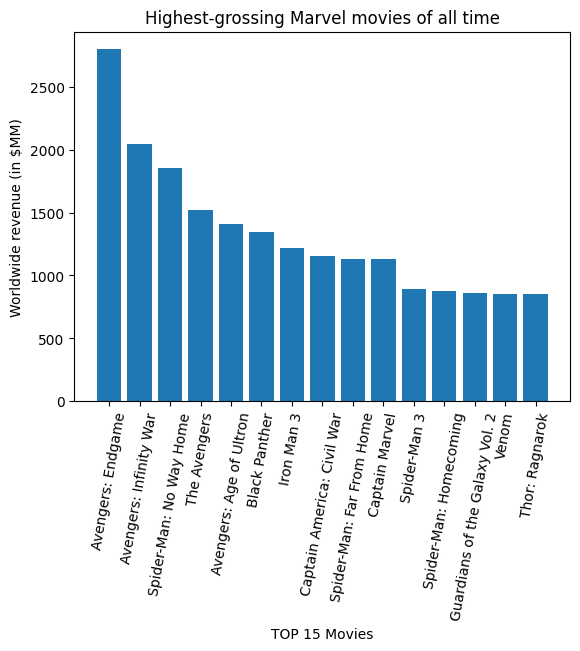

In [30]:
plot_top_hightest_grossing(15, './DataSourcesCSV/marvel.csv')

The following code snippet calculates all Spider-Man movies.

In [31]:
def get_movies_containing_string(string, movies_csv_path):
  """Returns a data frame containing the movies where the name contains the given string.
  The information about the movies is stored in a csv file at the given path.
  Format: Distributor | UsReleaseDate | BudgetInDolMill | NorthAmOpeningWeekendDolMill | NorthAmericaDolMill | OtherTerritoriesDolMill | WorldwideDolMill 

  Args:
      string (str): The string to look for.
      movies_csv_path (str): Path to the csv file containing information about the Marvel movies.

  Raises:
      TypeError: Is thrown if the string to look for is not a string.
      FileNotFoundError: Is thrown if the csv file at the given path is not found.

  Returns:
      DataFrame: The result data frame.
  """
  if type(string) != str:
      raise TypeError("string must be of type string!")
  if not(os.path.isfile(movies_csv_path)):
    raise FileNotFoundError('Could not find the csv file!')
  
  movies_frame = get_movies_frame(movies_csv_path)
  return movies_frame[movies_frame.index.str.contains(string)]

In [32]:
spider_man_movies = get_movies_containing_string('Spider', './DataSourcesCSV/marvel.csv')
spider_man_movies

,Distributor,UsReleaseDate,BudgetInDolMill,NorthAmOpeningWeekendDolMill,NorthAmericaDolMill,OtherTerritoriesDolMill,WorldwideDolMill
Title,,,,,,,
Spider-Man,Sony Pictures,May 3 2002,139.0,114.844116,403.706375,418.002176,821.708551
Spider-Man 2,Sony Pictures,June 30 2004,200.0,88.156227,373.585825,415.390628,788.976453
Spider-Man 3,Sony Pictures,May 4 2007,258.0,151.116516,336.530303,554.341323,890.871626
The Amazing Spider-Man,Sony Pictures,July 3 2012,230.0,62.004688,262.030663,495.900000,757.930663
The Amazing Spider-Man 2,Sony Pictures,May 2 2014,255.0,91.608337,202.853933,506.128390,708.982323
Spider-Man: Homecoming,Sony Pictures,July 7 2017,175.0,117.027503,334.201140,545.965784,880.166924
Spider-Man: Into the Spider-Verse,Sony Pictures,December 14 2018,90.0,35.363376,190.241310,185.299521,375.540831
Spider-Man: Far From Home,Sony Pictures,July 2 2019,160.0,92.579212,390.532085,741.395911,1131.927996
Spider-Man: No Way Home,Sony Pictures,December 17 2021,200.0,260.138569,780.418859,1072.000000,1852.418859


The following code snippet calculates all X-Men movies.

In [33]:
x_men_movies = get_movies_containing_string('X-Men', './DataSourcesCSV/marvel.csv')
x_men_movies

,Distributor,UsReleaseDate,BudgetInDolMill,NorthAmOpeningWeekendDolMill,NorthAmericaDolMill,OtherTerritoriesDolMill,WorldwideDolMill
Title,,,,,,,
X-Men,20th Century Fox,July 14 2000,75.0,54.471475,157.299717,139.039810,296.339527
X-Men: The Last Stand,20th Century Fox,May 26 2006,210.0,102.750665,234.362462,224.997093,459.359555
X-Men Origins: Wolverine,20th Century Fox,May 1 2009,150.0,85.058003,179.883157,193.179707,373.062864
X-Men: First Class,20th Century Fox,June 3 2011,160.0,55.101604,146.408305,207.215819,353.624124
X-Men: Days of Future Past,20th Century Fox,May 23 2014,200.0,90.823660,233.921534,513.941241,747.862775
X-Men: Apocalypse,20th Century Fox,May 27 2016,178.0,65.769562,155.442489,388.491616,543.934105


It can be clearly seen that Spider-Man also wins movie-wise over X-Men.

In [34]:
spider_man_movies = get_movies_containing_string('Spider', './DataSourcesCSV/marvel.csv')
x_men_movies = get_movies_containing_string('X-Men', './DataSourcesCSV/marvel.csv')
spider_man_movies_amount = len(spider_man_movies.index)
x_men_movies_amount = len(x_men_movies.index)
print(f'Amount of Spider-Man movies ever made: {spider_man_movies_amount}')
print(f'Amount of X-Men movies ever made: {x_men_movies_amount}')

Amount of Spider-Man movies ever made: 9
Amount of X-Men movies ever made: 6


Spider-Man also wins over X-Men when it comes to movie revenue.

In [35]:
spider_man_movies = get_movies_containing_string('Spider', './DataSourcesCSV/marvel.csv')
x_men_movies = get_movies_containing_string('X-Men', './DataSourcesCSV/marvel.csv')
average_revenue_spiderman = round(spider_man_movies['WorldwideDolMill'].mean(),1)
average_revenue_xmen = round(x_men_movies['WorldwideDolMill'].mean(), 1)
print(f'Average revenue of Spider-Man movies worldwide (in $MM) ever made: {average_revenue_spiderman}')
print(f'Average revenue of X-Men movies worldwide (in $MM) ever made: {average_revenue_xmen}')

Average revenue of Spider-Man movies worldwide (in $MM) ever made: 912.1
Average revenue of X-Men movies worldwide (in $MM) ever made: 462.4


### Conclusion

Based on the data above, it can be concluded that Spider-Man wins over X-Men also movie-wise.
The statement of Spider-Man's popularity can be supported by the fact that it leads the top 15 list of highest earning films of all time worldwide, alongside the Avengers, by number of films.

## Relationships between characters

This section explores the relationships between the Top 10 popular characters.

In [36]:
def calculate_relationships_of_top_popular_heroes(entity_type, heroes_json_config, top_count):
  """Calculates amount of common entities (e.g. comics) for all pair combinations of the characters stored as an JSON array in the JSON file at the given path.
  Top X (descending by the amount of the given entity) are calculated.
  The result is a data frame.
  Format: Character1 | Character2 | Common<EntityName>Amount

  Args:
      entity_type (str): The requested entity type (comics, series, stories or events).
      heroes_json_config (str): Represents the path to the JSON configuration containing a JSON array representing the characters of the Marvel universe.
      The characters are represented as JSON objects containing more information about them.
      top_count (int): Amount of TOP X to retrieve.

  Raises:
      TypeError: Is thrown if the entity type is not a string.
      ValueError: Is thrown if the entity type is not in the allowed entities.
      FileNotFoundError: Is thrown if the configuration file containing the characters is not found.
      TypeError: Is thrown if the TOP X count is not an integer.

  Returns:
      DataFrame: The result data frame.
  """
  if type(entity_type) != str:
    raise TypeError("entity_type must be a string!")
  if not(entity_type in ['comics', 'series', 'stories', 'events']):
      raise ValueError("entity_type was unknown!")
  if not(os.path.isfile(heroes_json_config)):
    raise FileNotFoundError('Could not find the JSON file!')
  if type(top_count) != int:
      raise TypeError("top_count has to be an integer!")
  
  calc = RelationShipCalculator(heroes_json_config)
  most_popular = get_most_popular_in_entity_type(heroes_json_config, entity_type, top_count)
  most_popular_list = list(most_popular['Name'])
  relationship_frame = calc.get_amount_of_common_entities_data_frame(most_popular_list, entity_type)
  key_value = calc.get_relationships_frame_key_based_on_entity_type(entity_type)
  sorted = relationship_frame.sort_values(by=key_value, ascending=False)
  result = sorted[(sorted[key_value] > 0)]
  return result    

In [37]:
def display_graph(input_tuples, title):
    """Displays the relationships between the characters contained in the input tuples.
    The relationships (which characters share common entities) can be seen as a graph.
    In order to avoid confusion if the amount of nodes is big, the amounts entities (weights of the edges) are not displayed.
    The input tuples have the followin format [((<Character-1-Name>, <Character-2-Name>), <Amount>), ...].

    Args:
        input_tuples (list): A list of tuples of the format mentioned above.
        title (str): The title of the graph.

    Raises:
        TypeError: Is thrown if the title is not a string.
        TypeError: Is thrown if input_tuples is not a list.
        TypeError: Is thrown if the list does not consist of tuples.
    """
    if type(title) != str:
        raise TypeError("title must be a string!")
    if type(input_tuples) != list:
        raise TypeError("input_tuples must be a list!")
    if not(all([type(el) == tuple for el in input_tuples])):
        raise TypeError("input_tuples must consist of tuples!")
    
    graph = nx.Graph()

    for edge in input_tuples:
        nodes, weight = edge
        node1, node2 = nodes
        graph.add_edge(node1, node2)
        
    pos = nx.circular_layout(graph)
    nx.draw(graph, pos, with_labels = True, font_weight='bold', font_size=10, font_color='black')
    labels = nx.get_edge_attributes(graph, 'weight')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
    plt.title(title)
    plt.show()

### Relationships between characters in series

In [38]:
relationships_in_series = calculate_relationships_of_top_popular_heroes('series', './DataSourcesJSON/characters.json', 10)
relationships_in_series

,Character1,Character2,CommonSeriesAmount
39,Thor,Hulk,10
25,Captain America,Iron Man,8
44,Fantastic Four,Daredevil,7
19,Wolverine,Iron Man,7
35,Iron Man,Thor,7
17,Wolverine,Captain America,6
21,Wolverine,Hulk,6
27,Captain America,Hulk,6
11,X-Men,Avengers,5
23,Wolverine,Daredevil,5


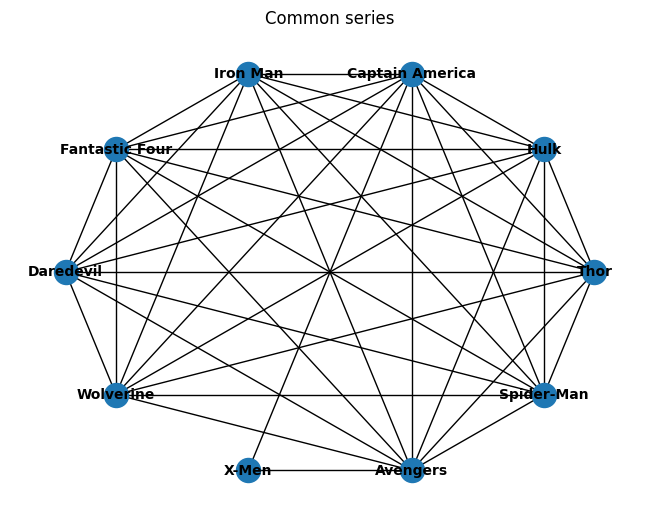

In [39]:
tuples = list(relationships_in_series.itertuples(index=False, name=None))
shorten_spiderman = lambda x: 'Spider-Man' if x == 'Spider-Man (Peter Parker)' else x
input_tuples = [((shorten_spiderman(el[0]), shorten_spiderman(el[1])), el[2]) for el in tuples]
display_graph(input_tuples, 'Common series')

### Relationships between characters in comics

In [40]:
relationships_in_comics = calculate_relationships_of_top_popular_heroes('comics', './DataSourcesJSON/characters.json', 10)
relationships_in_comics

,Character1,Character2,CommonComicsAmount
20,Iron Man,Thor,6
12,X-Men,Avengers,5
35,Avengers,Thor,4
21,Iron Man,Hulk,4
19,Iron Man,Avengers,4
24,Wolverine,Captain America,3
41,Thor,Daredevil,3
39,Thor,Hulk,3
29,Wolverine,Daredevil,2
30,Captain America,Avengers,2


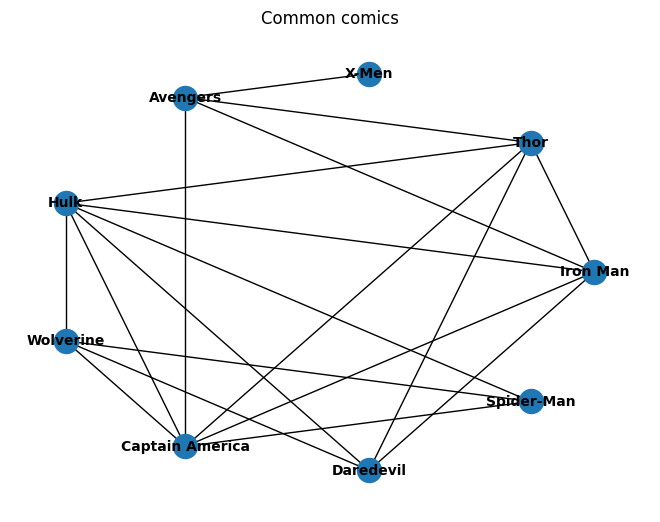

In [41]:
tuples = list(relationships_in_comics.itertuples(index=False, name=None))
shorten_spiderman = lambda x: 'Spider-Man' if x == 'Spider-Man (Peter Parker)' else x
input_tuples = [((shorten_spiderman(el[0]), shorten_spiderman(el[1])), el[2]) for el in tuples]
display_graph(input_tuples, 'Common comics')

### Relationships between characters in stories

In [42]:
relationships_in_stories = calculate_relationships_of_top_popular_heroes('stories', './DataSourcesJSON/characters.json', 10)
relationships_in_stories

,Character1,Character2,CommonStoriesAmount
11,X-Men,Wolverine,5
17,Iron Man,Captain America,5
25,Captain America,Avengers,4
19,Iron Man,Avengers,4
7,Spider-Man (Peter Parker),Fantastic Four,4
44,Fantastic Four,Daredevil,1
24,Captain America,Wolverine,1
1,Spider-Man (Peter Parker),Iron Man,1
20,Iron Man,Thor,1
18,Iron Man,Wolverine,1


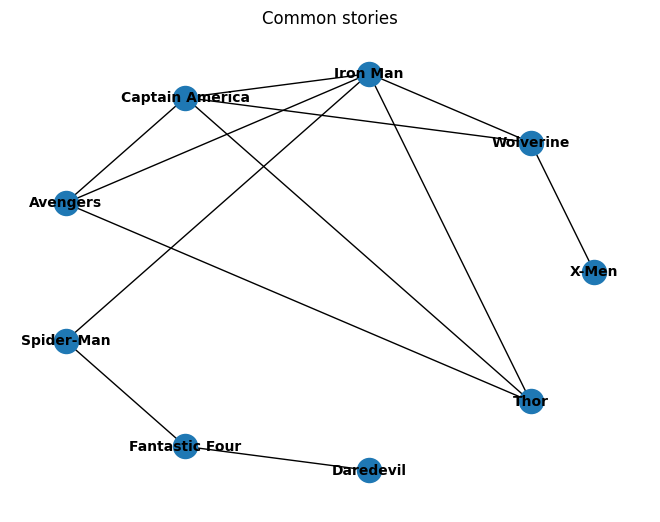

In [43]:
tuples = list(relationships_in_stories.itertuples(index=False, name=None))
shorten_spiderman = lambda x: 'Spider-Man' if x == 'Spider-Man (Peter Parker)' else x
input_tuples = [((shorten_spiderman(el[0]), shorten_spiderman(el[1])), el[2]) for el in tuples]
display_graph(input_tuples, 'Common stories')

### Relationships between characters in events

In [44]:
relationships_in_events = calculate_relationships_of_top_popular_heroes('events', './DataSourcesJSON/characters.json', 10)
relationships_in_events

,Character1,Character2,CommonEventsAmount
0,X-Men,Wolverine,19
14,Wolverine,Beast,18
6,X-Men,Beast,18
7,X-Men,Cyclops,16
24,Avengers,Iron Man,16
40,Storm,Cyclops,16
15,Wolverine,Cyclops,16
42,Beast,Cyclops,16
39,Storm,Beast,15
9,Wolverine,Spider-Man (Peter Parker),15


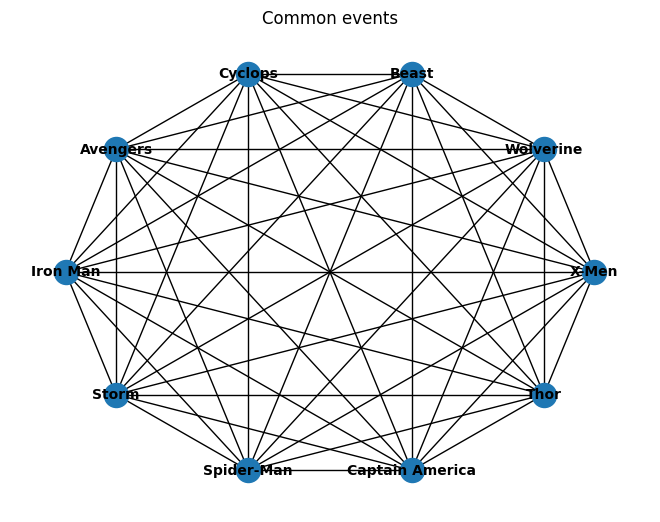

In [45]:
tuples = list(relationships_in_events.itertuples(index=False, name=None))
shorten_spiderman = lambda x: 'Spider-Man' if x == 'Spider-Man (Peter Parker)' else x
input_tuples = [((shorten_spiderman(el[0]), shorten_spiderman(el[1])), el[2]) for el in tuples]
display_graph(input_tuples, 'Common events')

### Conclusion

The graphs that simulate common appearances in comics, series and stories do not show any findings.
In the graph for events, a coherent connection can be recognized, namely that all heroes share certain events.
Furthermore, an interesting statement can be made here, namely that Spider-Man and Wolverine take the fourth place in terms of the number of common events (15 common events).
Wolverine is in first place and shares 19 events with X-Men.
This is a clear connection to the statement that he clearly leads X-Men in terms of the number of appearances in events.